In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
from pathlib import Path
import os

data_dir = Path('./data/')
data_path = Path('./data/fashion_mnist.npz')

if data_path.is_file():
    print('Data found. Loading...')
    data = np.load(data_path)
    X_train, Y_train, X_test, Y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
else:
    print('Data not found. Downloading...')
    if not data_dir.is_dir():
        os.mkdir(data_dir)
    from keras.datasets import fashion_mnist
    (X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
    X_train, X_test = X_train/255., X_test/255.
    np.savez_compressed(data_path, X_train, Y_train, X_test, Y_test)

Data found. Loading...


In [3]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
CLASS_LABELS = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

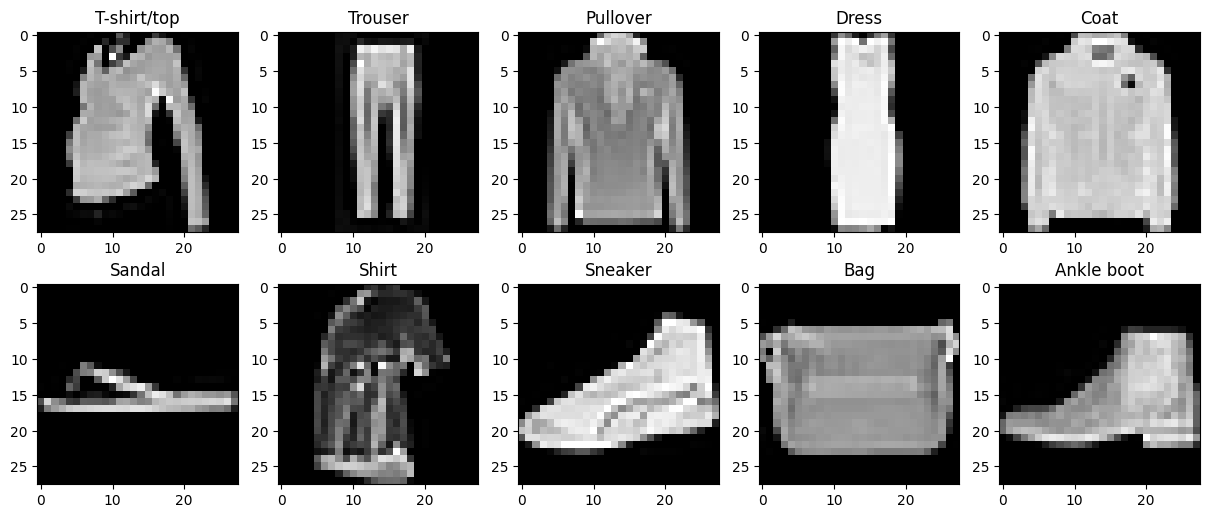

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row_no = i//5
    col_no = i%5
    X_sub = X_train[Y_train==i]
    index = np.random.choice(a=range(len(X_sub)), size=1)
    ax[row_no][col_no].imshow(X_sub[index].reshape((28, 28)), cmap='gray')
    ax[row_no][col_no].set_title(CLASS_LABELS[i])

## Activations

In [6]:
class Identity():
    """
    Implements the identity function, f(x) = x
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns identity(x) for input x

        Arg: x (np.array): The input
        Returns: identity(x) (np.array): The output, identity(x) (= x) 
        """
        return x
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of identity output wrt inputs, given the output

        Args:
            output (np.array): The output produced by the identity activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the identity activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return np.ones_like(output)

In [7]:
class Sigmoid():
    """
    Implements the sigmoid logistic function, f(x) = 1/(1 + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns sigmoid(x) for input x

        Arg: x (np.array): The input
        Returns: sigmoid(x) (np.array): The output, sigmoid(x)
        """
        return 1 / (1 + np.exp(-x))
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of sigmoid outputs wrt inputs, given the output

        Args:
            output (np.array): The output produced by the sigmoid activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the sigmoid activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return output * (1 - output)

In [8]:
class ReLU():
    """
    Implements the rectified linear unit (ReLU) function, f(x) = max(0, x) 
    """
    def __init__(self) -> None:
        pass
        
    def forward(self, x: np.array) -> np.array:
        """
        Returns relu(x) for input x

        Arg: x (np.array): The input
        Returns: relu(x) (np.array): The output, relu(x)
        """
        return np.maximum(0., x)
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of relu outputs wrt inputs, given the output

        Args:
            output (np.array): The output produced by the relu activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the relu activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        return np.sign(output, dtype=np.float64)

In [9]:
class Tanh():
    """
    Implements the hyperbolic tan (tanh) function, f(x) = (exp(x) - exp(-x))/(exp(x) + exp(-x))
    """
    def __init__(self) -> None:
        pass

    def forward(self, x: np.array) -> np.array:
        """
        Returns tanh(x) for input x

        Arg: x (np.array): The input
        Returns: tanh(x) (np.array): The output, tanh(x)
        """
        # tanh(x) = (exp(2x) - 1)/(exp(2x) + 1) = 2 / (1 + exp(-2x)) - 1
        return 2 / (1 + np.exp(-2*x)) - 1
    
    def backward(self, output: np.array, y_true=None) -> np.array:
        """
        Returns gradient of tanh outputs wrt inputs, given the output

        Args:
            output (np.array): The output produced by the tanh activation, corresponding to the input for which gradient
                is being computed.
            y_true (optional): Compatibility feature, required for softmax activation. Not used in computation.
                Defaults to None.
        
        Returns:
            grad (np.array): The gradient of the tanh activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        # d(tanh(x))/dx = 4exp(2x)/(1 + exp(2x))**2
        # exp(2x)/(1 + exp(2x)) = (tanh(x) + 1)/2, 1/(1 + exp(2x)) = (1 - tanh(x))/2
        # d(tanh(x))/dx = 1 - tanh(x)**2
        return 1 - output**2

In [10]:
class Softmax():
    """
    Implements the softmax function, f(x) = exp(x) / sum(exp(x))
    """
    def __init__(self, eps: float=1e-8) -> None:
        self.eps = eps

    def forward(self, x: np.array) -> np.array:
        """
        Returns softmax(x) for input x

        Arg: x (np.array): The input
        Returns: softmax(x) (np.array): The output, softmax(x)
        """
        max_x = np.max(x, axis=-1).reshape(-1, 1)
        exp_x = np.exp(x - max_x) + self.eps
        total = np.sum(exp_x, axis=-1).reshape(-1, 1)
        # return np.maximum((exp_x / total).reshape(x.shape), self.eps)
        return (exp_x / total).reshape(x.shape)
    
    def backward(self, output: np.array, y_true) -> np.array: 
        """
        Returns gradient of softmax outputs wrt inputs, given the output and true class

        Args:
            output (np.array): The output produced by the softmax activation, corresponding to the input for which gradient
                is being computed.
            y_true : The true classes corresponding to the producing outputs. Could be a scalar or an array.
        
        Returns:
            grad (np.array): The gradient of the softmax activation wrt the required inputs (for which the output is passed
                as proxy)
        """
        # e_l = np.zeros_like(output)
        # if len(output.shape) == 1:
        #     e_l[y_true] = 1.
        #     return output[y_true] * (e_l - output)
        # else:
        #     for i,y in enumerate(y_true):
        #         e_l[i][y] = 1.
        #     relevant_outputs = np.array([output[i][y] for i,y in enumerate(y_true)]).reshape(-1, 1)
        #     return relevant_outputs * (e_l - output)
        if len(output.shape) == 1:
            return output * np.eye(len(output)) - np.matmul(output.reshape(-1, 1), output.reshape(1, -1))
        else:
            return np.array([op * np.eye(len(op)) - np.matmul(op.reshape(-1, 1), op.reshape(1, -1)) for op in output])
        
# Attempt Xavier initialization and check if gradient problem goes away
        

## Loss functions

In [11]:
class CrossEntropyLoss():
    """
    Implements the cross entropy loss, L(y_hat, y) = -log(y_hat[y]) [where y is the true class label, from 0 to num_classes-1]

    Arg: eps (float, optional): quantity added to predicted probability for stability during log and division.
        Deafults to 1e-8.
    """
    def __init__(self, eps: float=1e-8) -> None:
        self.eps = eps

    def forward(self, y_pred: np.array, y_true) -> np.float64:
        """
        Returns the loss for predicted probabilities y_pred, with true class label y_true

        Args:
            y_pred (np.array): The predicted probabilities of each of the classes. 
                Array of shape (num_classes,) or (num_samples, num_classes).
            y_true: The true class label(s) of the data point(s). Could be a scalar or an array of shape (num_samples,).

        Returns:
            The (average) cross entropy loss (across all samples), a np.float64 object.
        """
        if len(y_pred.shape) == 1:
            # return -np.log(np.minimum(y_pred[y_true] + self.eps, 1.))
            return -np.log(y_pred[y_true])
        else:
            return np.mean(np.array([
                # -np.log(np.minimum(y_pred[i][y] + self.eps, 1.)) for i,y in enumerate(y_true)
                -np.log(y_pred[i][y]) for i,y in enumerate(y_true)
            ]))
    
    def backward(self, y_pred: np.array, y_true) -> np.array:
        """
        Returns the derivative of the loss wrt the predicted probability of the true class y_true

        Args:
            y_pred (np.array): The predicted probabilities of each of the classes. 
                Array of shape (num_classes,) or (num_samples, num_classes).
            y_true: The true class label(s) of the data point(s). Could be a scalar or an array of shape (num_samples,).

        Returns:
            grad (np.array): The gradient of the loss wrt the inputs (probabilties) given to the loss function.
                Array of shape matching y_pred.
        """
        grad = np.zeros_like(y_pred)
        if len(y_pred.shape) == 1:
            # grad[y_true] = -1 / (np.minimum(y_pred[y_true] + self.eps, 1.))
            grad[y_true] = -1 / y_pred[y_true]
        else:
            for i,y in enumerate(y_true):
                # grad[i][y] = -1 / (np.minimum(y_pred[i][y] + self.eps, 1.))
                grad[i][y] = -1 / y_pred[i][y]
        return grad




## Metrics

In [12]:
def categorical_accuracy(Y_true, Y_pred) -> float:
    if len(Y_pred.shape) == 1:
        return 1. if np.argmax(Y_pred) == Y_true else 0.
    else:
        Y_pred_class = np.argmax(Y_pred, axis=1)
        return np.sum(Y_pred_class == Y_true) / len(Y_true)

## Feedforward neural network

In [13]:
class Layer():
    """
    Models a single layer of a feedforward neural network. 

    Args:
        input_size (int): number of inputs to the layer
        output_size (int): number of outputs produced by the layer
        activation (str, optional): activation function used by the layer. 
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu', 'softmax'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        if weight_init == 'xavier':
            self.w = np.random.normal(scale=np.sqrt(2/(input_size + output_size)), size=(output_size, input_size))
            self.b = np.random.normal(scale=np.sqrt(2/(input_size + output_size)), size=(output_size,))
        else:
            self.w = np.random.normal(size=(output_size, input_size))   # shape: (output_size, input_size)
            self.b = np.random.normal(size=(output_size,))  # shape: (output_size,)
        self.grad_w = np.zeros_like(self.w)
        self.grad_b = np.zeros_like(self.b)
        if activation == 'identity' or activation.__class__ == Identity:
            self.activation = Identity()
        elif activation == 'sigmoid' or activation.__class__ == Sigmoid:
            self.activation = Sigmoid()
        elif activation == 'tanh' or activation.__class__ == Tanh:
            self.activation = Tanh()
        elif activation == 'relu' or activation.__class__ == ReLU:
            self.activation = ReLU()
        elif activation == 'softmax' or activation.__class__ == Softmax:
            self.activation = Softmax()
    
    def forward(self, x: np.array, eval_mode: bool = False) -> np.array:
        """
        Computes the output of the layer for given input.

        Args: 
            x (np.array): the input vector for the layer, of size (input_size,) or (num_samples, input_size).
            eval_mode (bool, optional): whether to compute in eval mode, without storing input, pre-activation and output.
                Defaults to False.
        Returns: h (np.array): the output produced by the layer, of size (output_size,) or (num_samples, output_size).
        """
        if not eval_mode:
            self.input = x
            self.pre_activation = np.matmul(x, self.w.T) + self.b
            self.output = self.activation.forward(self.pre_activation)
            return self.output
        else:
            return self.activation.forward(np.matmul(x, self.w.T) + self.b)
    
    def backward(self, accumulated_grads: np.array, y_true=None, w_next: np.array = None) -> np.array:
        """
        Computes the relevant necessary gradients of the layer, given the gradient accumulated until the succeeding layer.

        Args:
            accumulated_grads (np.array): gradient accumulated from the loss until the following layer, i.e. grad(L) wrt a_(i+1)
                Array of shape (num_features,) or (num_samples, num_features).
            y_true (optional): compatiblity feature, required only for the output layer for softmax activation.
                Defaults to None.
            w_next (np.array, optional): weight associated with the succeeding layer. Not applicable for the output layer.
                Defaults to None.
        
        Returns: grad_to_return (np.array), gradient accumulated until the current layer, i.e., grad(L) wrt a_i
        """
        # accumulated_grads ~ grad(L) wrt a_i+1
        activation_grad = self.activation.backward(self.output, y_true)
        if w_next is not None:
            grad_to_return = np.matmul(accumulated_grads, w_next) * activation_grad
        else:
            if len(self.output.shape) == 1:
                grad_to_return = np.matmul(accumulated_grads.reshape(1, -1), activation_grad)
            else:
                grad_to_return = np.array([np.matmul(accumulated_grads[i].reshape(1, -1), activation_grad[i]).reshape(-1) for i in range(len(accumulated_grads))])
            # grad_to_return = accumulated_grads * activation_grad # shape = self.output.shape
        # grad_to_return ~ grad(L) wrt a_i
        self.grad_w += np.matmul(grad_to_return.T.reshape(self.w.shape[0], -1), self.input.reshape(-1, self.w.shape[1])) / self.input.reshape(-1, self.w.shape[1]).shape[0]
        if len(self.input.shape) == 1:
            self.grad_b += grad_to_return
        else:
            self.grad_b += np.mean(grad_to_return, axis=0)
        return grad_to_return

In [14]:
class FeedForwardNeuralNetwork():
    """
    Models a vanilla feedforward neural network, with softmax activation for the outputs.

    Args:
        num_layers (int): number of hidden layers in the network
        hidden_size (int): number of neurons per hidden layer
        input_size (int): size/dimension of inputs given to the network. 
            Defaults to 784, flattened size of mnist/fashion-mnist data.
        output_size (int): number of outputs produced by the network.
            Defaults to 10, number of classes of mnist/fashion-mnist data.
        activation (str, optional): activation function for the hidden layers.
            Allowed activations: 'identity', 'sigmoid', 'tanh', 'relu'
            Defaults to 'sigmoid'.
        weight_init (str, optional): type of initialization to be performed for the weights and biases
            Allowed initializations: 'random', 'xavier'
            Defaults to 'random'.
    """
    def __init__(
        self,
        num_layers: int,
        hidden_size: int,
        input_size: int = 784,
        output_size: int = 10,
        activation = 'sigmoid',
        weight_init: str = 'random'
    ) -> None:
        self.input_layer = Layer(input_size, hidden_size, activation, weight_init)
        self.hidden_layers = []
        for i in range(num_layers):
            self.hidden_layers.append(Layer(hidden_size, hidden_size, activation, weight_init))
        self.output_layer = Layer(hidden_size, output_size, 'softmax', weight_init)
    
    def forward(self, x: np.array, eval_mode: bool = False) -> np.array:
        """
        Computes the output of the network for given input.

        Args: 
            x (numpy.array): the input to the network, of size (input_size,) or (num_samples, input_size)
            eval_mode (bool, optional): whether to compute in eval mode, without storing input, pre-activation and output
            in each layer. Defaults to False.
        Returns: y_hat (numpy.array): the output produced by the network, of size (output_size,) or (num_samples, output_size)
        """
        result = self.input_layer.forward(x, eval_mode)
        for hidden_layer in self.hidden_layers:
            result = hidden_layer.forward(result, eval_mode)
        return self.output_layer.forward(result, eval_mode)
    
    def backward(self, accumulated_grads: np.array, y_true) -> None:
        """
        Computes the gradient of the loss wrt all the parameters (weights, biases) of the network, given the gradient of the loss
        wrt the output of the network.

        Args:
            accumulated_grads (np.array): gradient of the loss wrt the outputs of the network
                Array of size (num_classes,) or (num_samples, num_classes).
            y_true: the true class label(s) for the data input(s) to the network
        """
        self.y_true = y_true
        accumulated_grads = self.output_layer.backward(accumulated_grads, y_true)
        w_next = self.output_layer.w
        for hidden_layer in reversed(self.hidden_layers):
            accumulated_grads = hidden_layer.backward(accumulated_grads, w_next=w_next)
            w_next = hidden_layer.w
        self.input_layer.backward(accumulated_grads, w_next=w_next)
    
    def zero_grad(self) -> None:
        """
        Sets the gradients of all the parameters of the network to zero.
        """
        self.output_layer.grad_w, self.output_layer.grad_b = 0., 0.
        for hidden_layer in self.hidden_layers:
            hidden_layer.grad_w, hidden_layer.grad_b = 0., 0.
        self.input_layer.grad_w, self.input_layer.grad_b = 0., 0.
    
    def update_weights(self, lr: float = 1e-3) -> None: # DEPRECATE
        """
        Updates the parameters of the network along the direction of the negative gradient.

        Arg: lr (float, optional): learning rate for the update. Defaults to 1e-3.
        """
        self.output_layer.w -= lr * self.output_layer.grad_w
        self.output_layer.b -= lr * self.output_layer.grad_b
        for hidden_layer in self.hidden_layers:
            hidden_layer.w -= lr * hidden_layer.grad_w
            hidden_layer.b -= lr * hidden_layer.grad_b
        self.input_layer.w -= lr * self.input_layer.grad_w
        self.input_layer.b -= lr * self.input_layer.grad_b
        

## Optimizers

In [15]:
class StochasticGradientDescent():
    """
    Class to implement stochastic (mini-batch vanilla) gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.model.output_layer.w -= self.lr * (self.model.output_layer.grad_w + self.weight_decay * self.model.output_layer.w)
        self.model.output_layer.b -= self.lr * (self.model.output_layer.grad_b + self.weight_decay * self.model.output_layer.b)
        for hidden_layer in self.model.hidden_layers:
            hidden_layer.w -= self.lr * (hidden_layer.grad_w + self.weight_decay * hidden_layer.w)
            hidden_layer.b -= self.lr * (hidden_layer.grad_b + self.weight_decay * hidden_layer.b)
        self.model.input_layer.w -= self.lr * (self.model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w)
        self.model.input_layer.b -= self.lr * (self.model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b)


In [16]:
class MomentumGradientDescent():
    """
    Class to implement momentum-based gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        beta (float, optional): The momentum to be used, quantifying the confidence in the history of updates.
            Should range from 0 to 1. Defaults to 0.9.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        beta: float = 0.9,
        weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.beta = beta
        self.lr = lr
        self.weight_decay = weight_decay
        self.input_u_w = np.zeros_like(model.input_layer.w)
        self.input_u_b = np.zeros_like(model.input_layer.b)
        self.hidden_u_ws = []
        self.hidden_u_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_u_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_u_bs.append(np.zeros_like(hidden_layer.b))
        self.output_u_w = np.zeros_like(model.output_layer.w)
        self.output_u_b = np.zeros_like(model.output_layer.b)

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.output_u_w = self.beta * self.output_u_w + self.lr * (self.model.output_layer.grad_w + self.weight_decay * self.model.output_layer.w)
        self.model.output_layer.w -= self.output_u_w
        self.output_u_b = self.beta * self.output_u_b + self.lr * (self.model.output_layer.grad_b + self.weight_decay * self.model.output_layer.b)
        self.model.output_layer.b -= self.output_u_b
        for hidden_layer, hidden_u_w, hidden_u_b in zip(self.model.hidden_layers, self.hidden_u_ws, self.hidden_u_bs):
            hidden_u_w = self.beta * hidden_u_w + self.lr * (hidden_layer.grad_w + self.weight_decay * hidden_layer.w)
            hidden_layer.w -= hidden_u_w
            hidden_u_b = self.beta * hidden_u_b + self.lr * (hidden_layer.grad_b + self.weight_decay * hidden_layer.b)
            hidden_layer.b -= hidden_u_b
        self.input_u_w = self.beta * self.input_u_w + self.lr * (self.model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w)
        self.model.input_layer.w -= self.input_u_w
        self.input_u_b = self.beta * self.input_u_b + self.lr * (self.model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b)
        self.model.input_layer.b -= self.input_u_b

In [17]:
class NesterovGradientDescent():
    """
    Class to implement Nesterov accelerated gradient descent optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        beta (float, optional): The momentum to be used, quantifying the confidence in the history of updates (and the lookahead).
            Should range from 0 to 1. Defaults to 0.9.
        loss_fn (Any, optional): The loss function used in training the model, used to calculate the lookahead gradient.
            Defaults to CrossEntropyLoss().
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
        self,
        model: FeedForwardNeuralNetwork,
        lr: float = 1e-3,
        beta: float = 0.9,
        loss_fn = CrossEntropyLoss(),
        weight_decay : float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.beta = beta
        self.loss_fn = loss_fn
        self.weight_decay = weight_decay
        self.input_u_w = np.zeros_like(model.input_layer.w)
        self.input_u_b = np.zeros_like(model.input_layer.b)
        self.hidden_u_ws = []
        self.hidden_u_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_u_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_u_bs.append(np.zeros_like(hidden_layer.b))
        self.output_u_w = np.zeros_like(model.output_layer.w)
        self.output_u_b = np.zeros_like(model.output_layer.b)
    
    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        projected_model = FeedForwardNeuralNetwork(
            num_layers=len(self.model.hidden_layers),
            hidden_size=self.model.input_layer.b.shape[0],
            input_size=self.model.input_layer.w.shape[1],
            output_size=self.model.output_layer.b.shape[0],
            activation=self.model.input_layer.activation
        )
        projected_model.input_layer.w = self.model.input_layer.w - self.beta * self.input_u_w
        projected_model.input_layer.b = self.model.input_layer.b - self.beta * self.input_u_b
        for projected_hidden_layer, curr_hidden_layer, hidden_u_w, hidden_u_b in zip(projected_model.hidden_layers, self.model.hidden_layers, self.hidden_u_ws, self.hidden_u_bs):
            projected_hidden_layer.w = curr_hidden_layer.w - self.beta * hidden_u_w
            projected_hidden_layer.b = curr_hidden_layer.b - self.beta * hidden_u_b
        projected_model.output_layer.w = self.model.output_layer.w - self.beta * self.output_u_w
        projected_model.output_layer.b = self.model.output_layer.b - self.beta * self.output_u_b
        # Model with lookahead parameters

        y_pred = projected_model.forward(self.model.input_layer.input)
        accumulated_grads = self.loss_fn.backward(y_pred, self.model.y_true)
        projected_model.backward(accumulated_grads, self.model.y_true)
        # Lookahead gradient computation

        self.input_u_w = self.beta * self.input_u_w + self.lr * (projected_model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w)
        self.model.input_layer.w -= self.input_u_w
        self.input_u_b = self.beta * self.input_u_b + self.lr * (projected_model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b)
        self.model.input_layer.b -= self.input_u_b
        for hidden_layer, projected_hidden_layer, hidden_u_w, hidden_u_b in zip(self.model.hidden_layers, projected_model.hidden_layers, self.hidden_u_ws, self.hidden_u_bs):
            hidden_u_w = self.beta * hidden_u_w + self.lr * (projected_hidden_layer.grad_w + self.weight_decay * hidden_layer.w)
            hidden_layer.w -= hidden_u_w
            hidden_u_b = self.beta * hidden_u_b + self.lr * (projected_hidden_layer.grad_b + self.weight_decay * hidden_layer.b)
            hidden_layer.b -= hidden_u_b
        self.output_u_w = self.beta * self.output_u_w + self.lr * (projected_model.output_layer.grad_w + self.weight_decay ( self.model.output_layer.w))
        self.model.output_layer.w -= self.output_u_w
        self.output_u_b = self.beta * self.output_u_b + self.lr * (projected_model.output_layer.grad_b + self.weight_decay ( self.model.output_layer.b))
        self.model.output_layer.b -= self.output_u_b
        # Parameter updates

In [18]:
class RMSProp():
    """
    Class to implement RMSProp optimization algorithm on a model.

    Args:
        model (FeedForwardNeuralNetwork): The model whose parameters are to be learned.
        lr (float, optional): The learning rate for the updates. Defaults to 1e-3.
        beta (float, optional): The momentum to be used, quantifying the confidence in the history of updates.
            Should range from 0 to 1. Defaults to 0.9.
        eps(float, optional): The amount to be added to the accumulated history, to add stability to computation.
            Defaults to 1e-8.
        weight_decay (float, optional): The L2-regularization to use for the parameters of the network.
            Defaults to 0.
    """
    def __init__(
            self,
            model: FeedForwardNeuralNetwork,
            lr: float = 1e-3,
            beta: float = 0.9,
            eps: float = 1e-8,
            weight_decay: float = 0.
    ) -> None:
        self.model = model
        self.lr = lr
        self.beta = beta
        self.eps = eps
        self.weight_decay = weight_decay
        self.input_v_w = np.zeros_like(model.input_layer.w)
        self.input_v_b = np.zeros_like(model.input_layer.b)
        self.hidden_v_ws = []
        self.hidden_v_bs = []
        for hidden_layer in model.hidden_layers:
            self.hidden_v_ws.append(np.zeros_like(hidden_layer.w))
            self.hidden_v_bs.append(np.zeros_like(hidden_layer.b))
        self.output_v_w = np.zeros_like(model.output_layer.w)
        self.output_v_b = np.zeros_like(model.output_layer.b)

    def step(self) -> None:
        """
        Performs one step/update to the parameters of the model, using grads computed by the model's backward function.
        """
        self.input_v_w = self.beta * self.input_v_w + (1 - self.beta) * self.model.input_layer.grad_w**2
        self.model.input_layer.w -= self.lr * (self.model.input_layer.grad_w + self.weight_decay * self.model.input_layer.w) / np.sqrt(self.input_v_w + self.eps)
        self.input_v_b = self.beta * self.input_v_b + (1 - self.beta) * self.model.input_layer.grad_b**2 
        self.model.input_layer.b -= self.lr * (self.model.input_layer.grad_b + self.weight_decay * self.model.input_layer.b) / np.sqrt(self.input_v_b + self.eps)
        for hidden_layer, hidden_v_w, hidden_v_b in zip(self.model.hidden_layers, self.hidden_v_ws, self.hidden_v_bs):
            hidden_v_w = self.beta * hidden_v_w + (1 - self.beta) * hidden_layer.grad_w**2
            hidden_layer.w -= self.lr * (hidden_layer.grad_w + self.weight_decay * hidden_layer.w) / np.sqrt(hidden_v_w + self.eps)
            hidden_v_b = self.beta * hidden_v_b + (1 - self.beta) * hidden_layer.grad_b**2
            hidden_layer.b -= self.lr * (hidden_layer.grad_b + self.weight_decay * hidden_layer.b) / np.sqrt(hidden_v_b + self.eps)
        self.output_v_w = self.beta * self.output_v_w + (1 - self.beta) * self.model.output_layer.grad_w**2
        self.model.output_layer.w -= self.lr * (self.model.output_layer.grad_w + self.weight_decay * self.model.output_layer.w) / np.sqrt(self.output_v_w + self.eps)
        self.output_v_b = self.beta * self.output_v_b + (1 - self.beta) * self.model.output_layer.grad_b**2 
        self.model.output_layer.b -= self.lr * (self.model.output_layer.grad_b + self.weight_decay * self.model.output_layer.b) / np.sqrt(self.output_v_b + self.eps)


## Helper functions

In [19]:
from typing import Dict, List

def train(
    model: FeedForwardNeuralNetwork,
    X_train: np.array,
    Y_train: np.array,
    X_val: np.array,
    Y_val: np.array,
    optimizer,
    loss_fn = CrossEntropyLoss(),
    metric = categorical_accuracy,
    epochs: int = 10,
    batch_size: int = 64
) -> Dict[str, List]:
    history = {
        'epoch': [],
        'train_loss': [],
        'train_score': [],
        'val_loss': [],
        'val_score': []
    }
    NUM_BATCHES = int(np.ceil(len(X_train)/batch_size))
    for epoch in range(epochs):
        train_loss = 0.0
        train_score = 0.0
        for batch in range(NUM_BATCHES):
            X_train_batch = X_train[batch*batch_size:np.minimum(batch_size*(batch+1), len(X_train))]
            Y_train_batch = Y_train[batch*batch_size:np.minimum(batch_size*(batch+1), len(X_train))]
            model.zero_grad()
            Y_pred_train = model.forward(X_train_batch)
            loss = loss_fn.forward(Y_pred_train, Y_train_batch)
            loss_grad = loss_fn.backward(Y_pred_train, Y_train_batch)
            model.backward(loss_grad, Y_train_batch)
            optimizer.step()
            train_loss += loss / NUM_BATCHES
            train_score += metric(Y_train_batch, Y_pred_train) / NUM_BATCHES
        Y_pred_val = model.forward(X_val, True)
        val_loss = loss_fn.forward(Y_pred_val, Y_val)
        val_score = metric(Y_val, Y_pred_val)
        history['epoch'].append(epoch+1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_score'].append(train_score)
        history['val_score'].append(val_score)
        print(f'[Epoch {epoch+1}/{epochs}] train loss: {train_loss:.6f}, val loss: {val_loss: .6f} || train score: {train_score:.6f}, val score: {val_score:.6f}')
    return history

In [20]:
def predict(
        model: FeedForwardNeuralNetwork,
        X: np.array
):
        return model.forward(X, True)

In [23]:
model = FeedForwardNeuralNetwork(4, 128, activation='sigmoid')
loss_fn = CrossEntropyLoss()
optimizer = StochasticGradientDescent(model, 0.1)
metric = categorical_accuracy

history = train(
    model,
    X_train.reshape(-1, 784),
    Y_train,
    X_train.reshape(-1, 784)[59000:],
    Y_train[59000:],
    optimizer,
    loss_fn,
    metric,
    epochs=10,
    batch_size=128
)

[Epoch 1/10] train loss: 1.136888, val loss:  0.765665 || train score: 0.616710, val score: 0.720000
[Epoch 2/10] train loss: 0.750825, val loss:  0.674554 || train score: 0.727007, val score: 0.753000
[Epoch 3/10] train loss: 0.677502, val loss:  0.630360 || train score: 0.752293, val score: 0.763000
[Epoch 4/10] train loss: 0.634801, val loss:  0.595877 || train score: 0.767663, val score: 0.781000
[Epoch 5/10] train loss: 0.605114, val loss:  0.569434 || train score: 0.779168, val score: 0.787000
[Epoch 6/10] train loss: 0.582738, val loss:  0.550163 || train score: 0.787180, val score: 0.797000
[Epoch 7/10] train loss: 0.564792, val loss:  0.534685 || train score: 0.793582, val score: 0.799000
[Epoch 8/10] train loss: 0.549729, val loss:  0.521078 || train score: 0.798946, val score: 0.801000
[Epoch 9/10] train loss: 0.536732, val loss:  0.508815 || train score: 0.803621, val score: 0.805000
[Epoch 10/10] train loss: 0.525303, val loss:  0.497730 || train score: 0.807786, val score

## Small-scale test

In [34]:
rng = np.random.default_rng()
X_train_small_unscaled = rng.integers(-10, 30, (200, 2))
Y_train_small = np.matmul(X_train_small_unscaled, np.array([1, -4])) % 2
X_train_small_unscaled.shape, Y_train_small.shape

((200, 2), (200,))

In [35]:
X_train_small_scaled = (X_train_small_unscaled + 10) / 40

In [36]:
np.random.seed(384)

model = FeedForwardNeuralNetwork(num_layers=1, hidden_size=2, input_size=2, output_size=2, activation='sigmoid', weight_init='xavier')
count = 0
loss_fn = CrossEntropyLoss()

In [40]:
print(model.input_layer.w, model.input_layer.b)
print(model.hidden_layers[0].w, model.hidden_layers[0].b)
print(model.output_layer.w, model.output_layer.b)

[[-0.49273956  0.65380943]
 [ 0.65365887  0.54351532]] [-1.27213124 -0.31322795]
[[ 0.70947346 -0.10920137]
 [-0.80874811 -0.46250622]] [0.28798326 1.30528329]
[[ 0.54584889 -1.05623667]
 [-1.02850766  0.67841867]] [ 0.88357116 -0.19373288]


In [41]:
X_train_small_scaled[0], Y_train_small[0]

(array([0.225, 0.75 ]), 1)

In [43]:
model.zero_grad()
Y_pred = model.forward(X_train_small_scaled[0])
loss = loss_fn.forward(Y_pred, Y_train_small[0])
loss_grad = loss_fn.backward(Y_pred, Y_train_small[0])
model.backward(loss_grad, Y_train_small[0])
print(model.input_layer.grad_w, model.input_layer.grad_b)
print(model.hidden_layers[0].grad_w, model.hidden_layers[0].grad_b)
print(model.output_layer.grad_w, model.output_layer.grad_b)

[[0.00940206 0.0313402 ]
 [0.00154585 0.00515285]] [0.04178694 0.00687046]
[[ 0.04968094  0.09576247]
 [-0.0292482  -0.05637734]] [ 0.17098035 -0.10065966]
[[ 0.          0.        ]
 [-0.42255692 -0.48232191]] [ 0.         -0.69661882]


In [44]:
print(model.output_layer.output)

[0.69661882 0.30338118]


In [45]:
grad_aout = - (np.array([0, 1]) - model.output_layer.output)
grad_aout

array([ 0.69661882, -0.69661882])

In [49]:
grad_wout = np.matmul(grad_aout.reshape(-1, 1), model.output_layer.input.reshape(-1, 1).T)
grad_wout

array([[ 0.42255692,  0.48232191],
       [-0.42255692, -0.48232191]])

In [25]:
optimizer = StochasticGradientDescent(model, lr=0.1)
loss_fn = CrossEntropyLoss()

In [26]:
def print_model_details(model: FeedForwardNeuralNetwork):
    print('Input layer weight:', model.input_layer.w)
    print('Input layer bias:', model.input_layer.b)
    print('Hidden layer weight:', model.hidden_layers[0].w)
    print('Hidden layer bias:', model.hidden_layers[0].b)
    print('Output layer weight:', model.output_layer.w)
    print('Output layer bias:', model.output_layer.b)
    
    print('Input layer weight gradient:', model.input_layer.grad_w)
    print('Input layer bias gradient:', model.input_layer.grad_b)
    print('Hidden layer weight gradient:', model.hidden_layers[0].grad_w)
    print('Hidden layer bias gradient:', model.hidden_layers[0].grad_b)
    print('Output layer weight gradient:', model.output_layer.grad_w)
    print('Output layer bias gradient:', model.output_layer.grad_b)

def print_intermediates(model: FeedForwardNeuralNetwork):
    print('Input:', model.input_layer.input)
    print('Input layer pre-activation:', model.input_layer.pre_activation)
    print('Input layer output:', model.input_layer.output)
    print('Hidden layer pre-activation:', model.hidden_layers[0].pre_activation)
    print('Hidden layer output:', model.hidden_layers[0].output)
    print('Output layer pre-activation:', model.output_layer.pre_activation)
    print('Output layer output:', model.output_layer.output)

In [27]:
print_model_details(model)

Input layer weight: [[-0.27332273  0.36266822  0.3625847 ]
 [ 0.30148805 -0.70565145 -0.17374761]
 [ 0.39354507 -0.06057402 -0.44861274]
 [-0.25655229  0.15974437  0.7240409 ]
 [ 0.30278249 -0.58589469 -0.5705134 ]
 [ 0.37631897  0.49011709 -0.10746367]
 [ 0.16734036  0.36289134  0.66128351]
 [ 0.00292486  0.34263207  0.44106116]
 [-0.01726162 -0.42624764 -0.15930964]
 [ 0.17258067 -0.86378157  0.37449577]]
Input layer bias: [ 0.24171995  0.51779148 -0.88279604 -0.38321432  0.04128801 -0.86583483
  0.30760588 -0.23250912 -0.27901413 -0.07009817]
Hidden layer weight: [[-0.05196967 -0.21304195  0.02546332 -0.05107187 -0.0974044  -0.3417984
  -0.29935158 -0.01507817 -0.12906296  0.03734594]
 [ 0.01016864  0.20483022  0.0137705  -0.08288059 -0.07911533  0.27757576
   0.00289474 -0.44346363  0.44272316  0.50618818]
 [-0.17050262 -0.19000085  0.25875323  0.09947229  0.15963418 -0.25965466
  -0.08067103 -0.33824162  0.20821238  0.13379946]
 [-0.12588571  0.08604619 -0.12006281 -0.10902088 -0.

In [67]:
model.zero_grad()
y_pred = model.forward(X_train_small_scaled)
loss = loss_fn.forward(y_pred, Y_train_small)
loss_grad = loss_fn.backward(y_pred, Y_train_small)
model.backward(loss_grad, Y_train_small)
optimizer.step()
count += 1

print(count, loss, sep='\t\t')
# print(loss_grad)
print_model_details(model)
print_intermediates(model)

40		9.106202677964367
Input layer weight: [[ 0.23479471  0.83785421  0.82983836]
 [ 1.21087674  0.12505234  0.64824358]
 [ 0.39354507 -0.06057402 -0.44861274]
 [-0.25650707  0.15064236  0.71526672]
 [ 0.27927454 -0.59238619 -0.57413352]
 [ 0.37631897  0.49011709 -0.10746367]
 [ 2.9899046   2.96094388  3.20328574]
 [ 1.71706631  1.91592647  1.98468433]
 [-0.01726162 -0.42624764 -0.15930964]
 [ 0.5203254  -0.63705244  0.70443233]]
Input layer bias: [ 1.2363733   2.28490683 -0.88279604 -0.39484775  0.01212238 -0.86583483
  5.82910282  3.11915881 -0.27901413  0.56558932]
Hidden layer weight: [[-5.19696652e-02 -2.13041947e-01  2.54633176e-02 -5.10718744e-02
  -9.74044048e-02 -3.41798403e-01 -2.99351575e-01 -1.50781660e-02
  -1.29062957e-01  3.73459430e-02]
 [ 8.80163835e-03  2.01355054e-01  1.37704965e-02 -8.31211696e-02
  -7.92498465e-02  2.77575759e-01 -2.09077755e-03 -4.44198613e-01
   4.42723164e-01  5.05173337e-01]
 [-1.70502622e-01 -1.90000849e-01  2.58753232e-01  9.94722864e-02
   1.

In [22]:
history = {
    'epoch': [],
    'loss': []
}

N = 3

for i in range(1000):
    model.zero_grad()
    y_pred = model.forward(X_train_small_scaled[:N])
    loss = loss_fn.forward(y_pred, Y_train_small[:N])
    loss_grad = loss_fn.backward(y_pred, Y_train_small[:N])
    model.backward(loss_grad, Y_train_small[:N])
    optimizer.step()
    print(i, loss, sep='\t')
    history['epoch'].append(i)
    history['loss'].append(loss)

0	1.4722747927766842
1	1.4460252096305346
2	1.4219284175769242
3	1.3993841735972916
4	1.3774474002763082
5	1.357204827009818
6	1.3381384885542378
7	1.3199799216711465
8	1.3025982313445212
9	1.2883038260886466
10	1.2742314713959493
11	1.260261790643795
12	1.2464226071943643
13	1.2327538883659643
14	1.2193092161053192
15	1.2061573166054977
16	1.1933834382315989
17	1.1810902109996342
18	1.1693973864552287
19	1.1584395295628118
20	1.148360326213737
21	1.1393017654432072
22	1.131386295682727
23	1.1246906641917926
24	1.1191896553702279
25	1.1146971479548586
26	1.1110797164740154
27	1.1079763230329986
28	1.1049912024049524
29	1.1018481507038957
30	1.0986110627816645
31	1.0959181678952574
32	1.0947879005933903
33	1.0949152082600284
34	1.0944070860952595
35	1.0958142575420555
36	1.115296995383798
37	7.801590352913693
38	7.9731983188085165
39	12.280453865968243
40	12.28045386596824
41	12.28045386596824
42	12.280453865968243
43	12.28045386596824
44	12.28045386596824
45	12.28045386596824
46	12.280

/tmp/ipykernel_38680/1549685513.py:49: RuntimeWarning: overflow encountered in matmul
  self.pre_activation = np.matmul(x, self.w.T) + self.b
/tmp/ipykernel_38680/1549685513.py:49: RuntimeWarning: invalid value encountered in matmul
  self.pre_activation = np.matmul(x, self.w.T) + self.b


Text(0, 0.5, 'Loss')

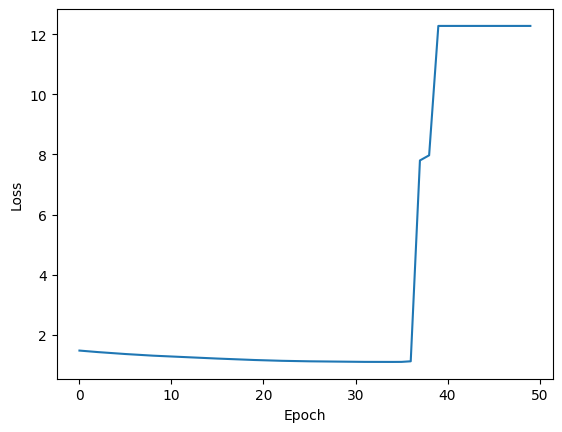

In [23]:
plt.plot(history['epoch'], history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')